# Io AMI Image Deconvolution

In [1]:
import os
os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots
from geckos_colourmap import geckos_div

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.core import AMIOptics, SUB80Ramp, BaseModeller
from amigo.fitting import optimise
from amigo.files import get_files, summarise_files, get_Teffs, get_filters, initialise_params, get_exposures

from io_funcs import initialise_disk, ComplexIoSource, HD2236, niriss_parang, get_filter_spectrum
from io_funcs import io_model_fn as model_fn
from plotting import get_extents, plotting_cal_comparison, plot_params, get_residual_bounds, get_residuals

# files
from zodiax.experimental import deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

sunset_dark = geckos_div(variation="geckos_sunset_darkred")
sunset = geckos_div(variation="geckos_sunset")

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [2]:
EXP_TYPE = "NIS_AMI"
FILTERS = ["F480M", "F430M", "F380M"]
# TARGPROP = ["HD-37093", "HD-36805"]
# TARGPROP = ["AB-DOR"]

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE=EXP_TYPE,
    FILTER=FILTERS,
    **kwargs,
)

files = file_fn()

print(f"\n{len(files)}")
summarise_files(
    files,
    [
        # "ACT_ID",
        "APERNAME",
        "PUPIL",
        "SUBARRAY",
        "DETECTOR",
        "EXP_TYPE",
        "NINTS",
        "NGROUPS",
        "TGROUP",
        "OBSERVTN",
        "VISIT",
        "VISITGRP",
        "SEQ_ID",
        "ACT_ID",
        "EXPOSURE",
    ],
)


9
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  EXP_TYPE: NIS_AMI
  NINTS: 8, 100
  NGROUPS: 12, 45
  TGROUP: 0.07544
  OBSERVTN: 017, 023
  VISIT: 001
  VISITGRP: 04, 03
  SEQ_ID: 1
  ACT_ID: 02
  EXPOSURE: 1, 5, 2, 3, 4


Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [3]:
nsci = 2
sci_files = []

ncal = 2
cal_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)
    elif file[0].header["TARGPROP"] == "PSFCAL.2022A-HD2236-K6":
        cal_files.append(file)
    else:
        print(f"Unkown target: {file[0].header['TARGPROP']}")

sci_files = sci_files[:nsci]
cal_files = cal_files[4-ncal:]

for f in sci_files:
    print(f[0].header["TARGPROP"], f[1].data.shape)

for f in cal_files:
    print(f[0].header["TARGPROP"], f[1].data.shape)

sci_files[0][0].header

IO (17, 80, 80)
IO (17, 80, 80)
PSFCAL.2022A-HD2236-K6 (11, 80, 80)
PSFCAL.2022A-HD2236-K6 (11, 80, 80)


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATE    = '2024-05-07T04:42:41.317' / UTC date file created                     
ORIGIN  = 'STSCI   '           / Organization responsible for creating file     
TIMESYS = 'UTC     '           / principal time system for time-related keywords
TIMEUNIT= 's       '           / Default unit applicable to all time values     
FILENAME= 'jw01373017001_04102_00003_0001_nis_calslope.fits' / Name of the file 
SDP_VER = '2023_2a '           / Data processing (DP) Software Version          
PRD_VER = 'PRDOPSSOC-063'      / S&OC Project Reference Database (PRD) Version  
OSS_VER = '008.004.011.000'    / Observatory Scheduling Software (OSS) Version  
GSC_VER = 'GSC2431 '        

## Data visualisation
The calslops files (exposures) are of shape $(\text{ngroups - 1}, \text{npix}, \text{npix})$. Since we have up the ramp data, each exposure has $\text{ngroups}$ images, shown in the plot below. The title of the image is the peak pixel brightness of that image. The plot is simply the data from the first exposure. 

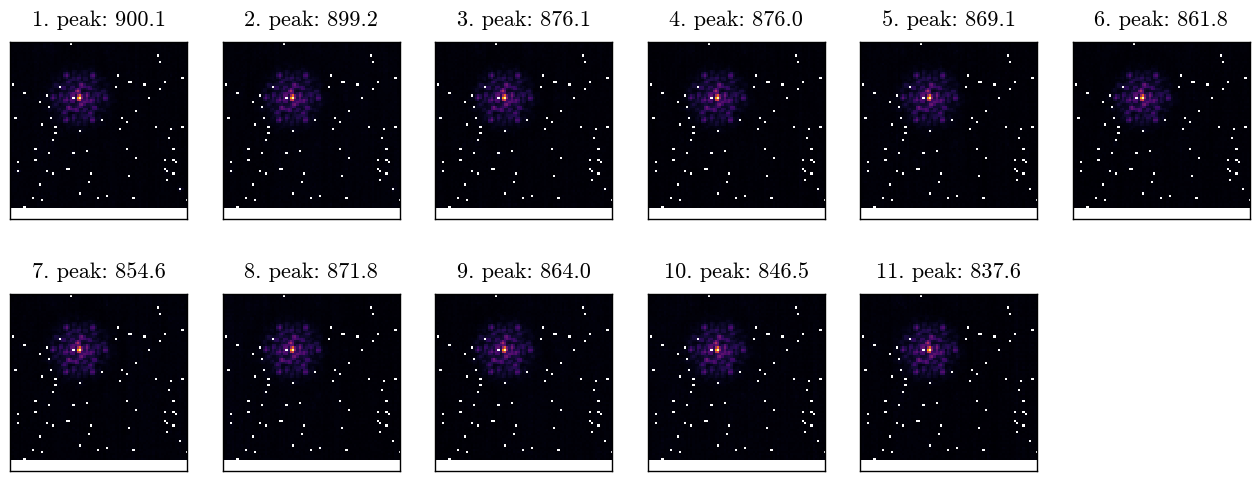

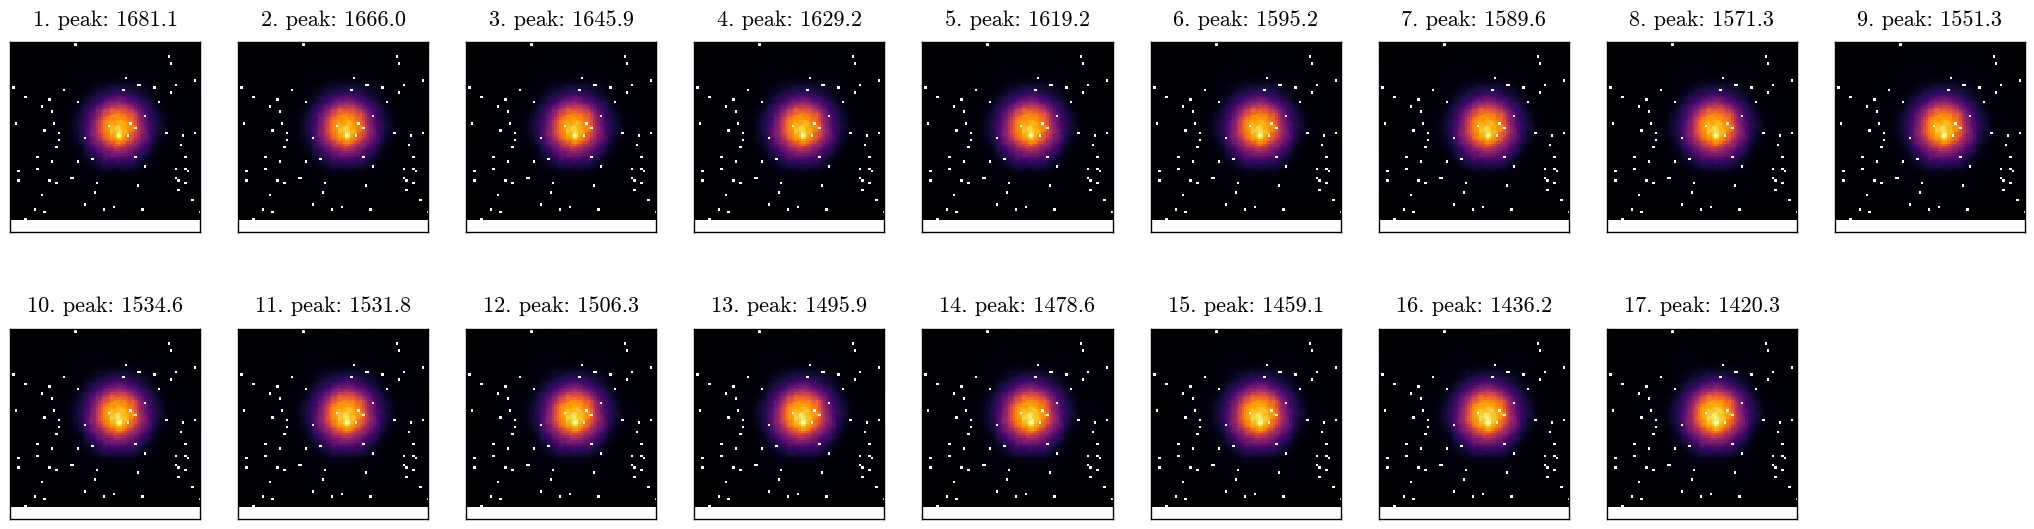

In [4]:
raw_data = np.asarray(cal_files[0][1].data, float)
# data = raw_data - raw_data[0]
cal_data = raw_data

plt.figure(figsize=(8, 3))
for i in range(cal_files[0][1].data.shape[0]):
    plt.subplot(2, 6, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(cal_data[i]):.1f}", size=8)
    plt.imshow(cal_data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()


raw_data = np.asarray(sci_files[0][1].data, float)
# data = raw_data - raw_data[0]
data = raw_data

plt.figure(figsize=(13, 9))
for i in range(sci_files[0][1].data.shape[0]):
    plt.subplot(5, 9, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(data[i]):.1f}", size=8)
    plt.imshow(data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()

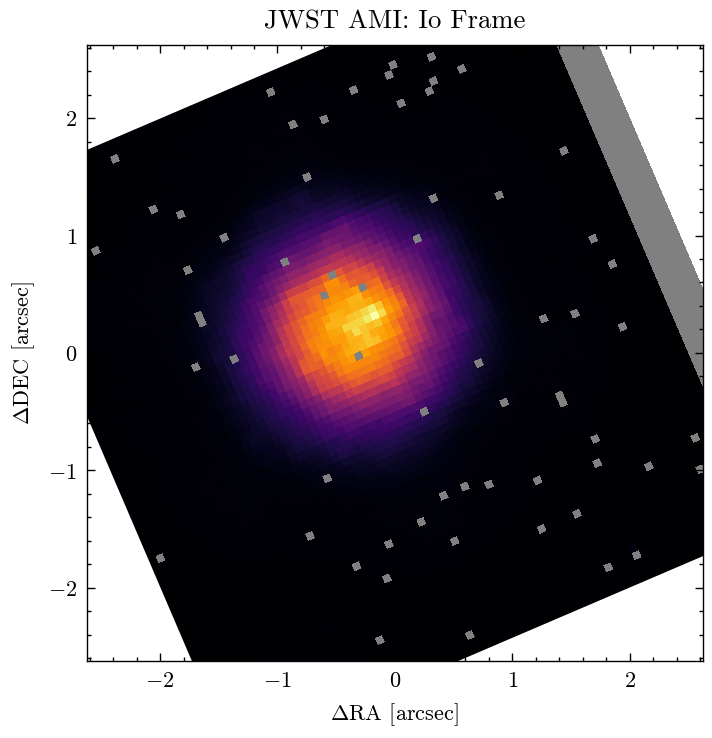

In [5]:
roll_angle = niriss_parang(sci_files[0][1].header)
niriss_pixel_scale = 0.0656  # arcsec/pixel


fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data[0], **get_extents(data[0], niriss_pixel_scale), cmap=inferno)
trans_data = Affine2D().rotate_deg(-roll_angle) + ax.transData
im.set_transform(trans_data)
ax.set(
    title="JWST AMI: Io Frame",
    xlabel=r"$\Delta$RA [arcsec]",
    ylabel=r"$\Delta$DEC [arcsec]",
)
plt.show()

# Building the model
First I am going to build some custom source classes.

Now we finally build the models. Let's first load in the BFE and mask models.

In [6]:
BFE = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_trained.zdx")
pupil_mask = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_AMI_mask.zdx")

And now instantiate and initialise values for the model.

In [7]:
# def get_exposures(files, optics=None, ms_thresh=None):
#     print("Prepping exposures...")
#     opds = get_wss_ops(files)
#     return [
#         # amigo.core.Exposure(file, opd=opd, add_read_noise=add_read_noise)
#         # amigo.core.Exposure(file, opd=opd, ms_thresh=ms_thresh)
#         # for file, opd in zip(files, opds)
#         amigo.core.ExposureFit(file, optics, opd=opd, ms_thresh=ms_thresh)
#         for file, opd in zip(files, opds)
#     ]

In [8]:
# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )

# Get detector and BFE
detector = SUB80Ramp()

# Processing exposures
cal_exposures = get_exposures(cal_files, optics)
cal_params = initialise_params(cal_exposures)

sci_exposures = get_exposures(sci_files, optics)
sci_params = initialise_params(sci_exposures)

filters = get_filters(files)
wavels, weights = filters["F430M"]

cal_params["filters"] = filters; sci_params["filters"] = filters
cal_params["optics"] = optics; sci_params["optics"] = optics
cal_params["detector"] = detector; sci_params["detector"] = detector
cal_params["BFE"] = BFE; sci_params["BFE"] = BFE

# Set log_fluxes
def set_fluxes(exposures, log_flux):
    log_fluxes = {}
    for exp in exposures:
        log_fluxes[exp.key] = log_flux
    return log_fluxes

# Calibrator
cal_params["source"] = HD2236(
    wavelengths=wavels,
    weights=weights,
)
cal_params["Teffs"] = get_Teffs(cal_files)  # TODO find this
cal_params["log_fluxes"] = set_fluxes(cal_exposures, 5.8)

# Io
params["source"] = ComplexIoSource(
    log_volcanoes=np.log10(initialise_disk(normalise=True)),
    # distribution=canon_io.data,
    spectrum=get_filter_spectrum("F430M", file_path="/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/data/niriss_filters/"),
)
sci_params["log_fluxes"] = set_fluxes(sci_exposures, 7.0)

# models
initial_model = BaseModeller(sci_params)
cal_model = BaseModeller(cal_params)

Prepping exposures...
Prepping exposures...
Searching for Teffs...


FileNotFoundError: [Errno 2] No such file or directory: 'files/Teffs/PSFCAL.2022A-HD2236-K6.npy'

And finally let's define a model function since we are using the `BaseModeller`.

# Calibrator Fit

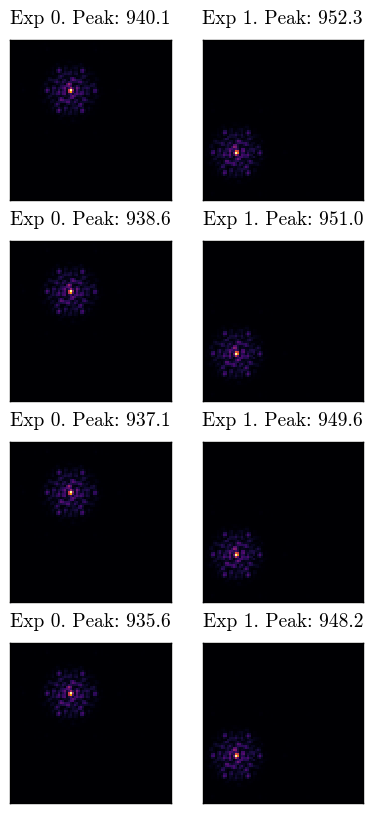

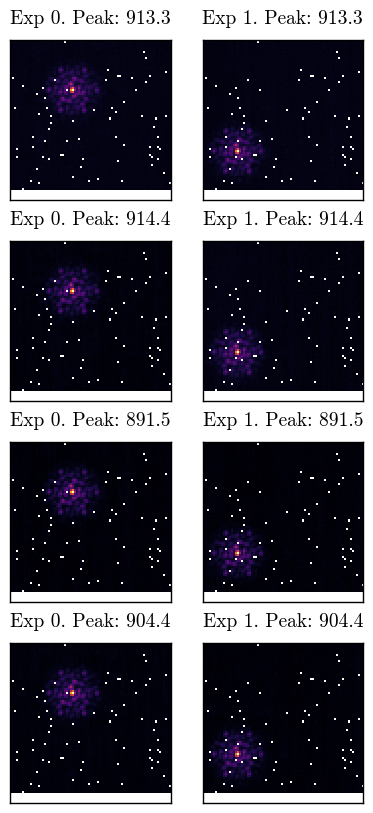

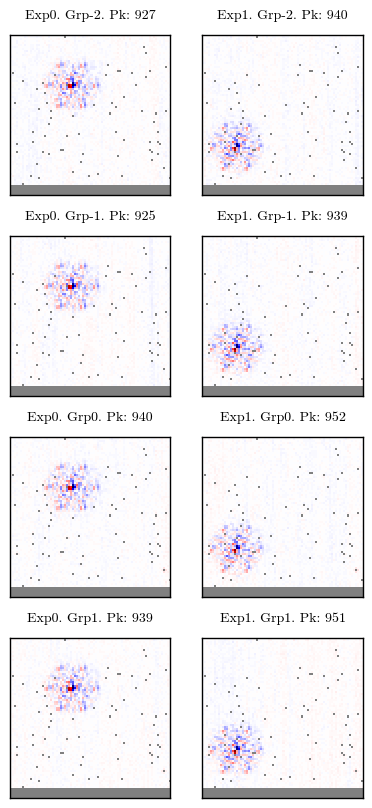

In [9]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    psf_ramp = model_fn(cal_model, exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.data
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(cal_data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.data
    psf_ramp = model_fn(cal_model, exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        residuals, bounds = get_residuals(psf_ramp[group_idx], exp.data[group_idx], return_bounds=True)
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(residuals, **bounds)
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


## Optimisation

In [10]:
def posterior(model, exposure, per_pix=True):
    ramp = model_fn(model, exposure)
    
    loglike = exposure.loglike_vec(ramp).sum()

    if per_pix:
        return loglike / np.prod(np.array(exposure.data.shape[-2:]))
    return loglike


def loss_fn(model, exposures):
    loss = -np.array([posterior(model, exp) for exp in exposures])
    return loss.sum()

delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
adam_opt = lambda lr, start: optax.adam(delay(lr, start))
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))

In [11]:
config = {
    "positions": opt(2e-6, 0),
    "aberrations":  opt(1e2, 8),
    # # # "aberrations":  clip(adam_opt(1e1, 30), 8),
    "log_fluxes": opt(2e-5, 15),
    
    # # Read noise refinement
    # "OneOnFs": opt(1e3, 60),
    # # "biases": opt(5e4, 50),

    # # BFE
    # "BFE.linear": opt(2e-7, 30),
    # "BFE.quadratic": opt(5e-17, 35),
}

# params = list(config.keys())

# Optimisation
cal_final_model, cal_losses, cal_params_out, cal_opt_state = optimise(
    cal_model,
    cal_exposures,
    loss_fn,
    10,
    config,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:09
Initial Loss: 293.58


Loss: 293.58, Change: 0.0:  10%|#         | 1/10 [00:00<?, ?it/s]

Full Time: 0:00:32
Final Loss: 81.60


## Visualisation

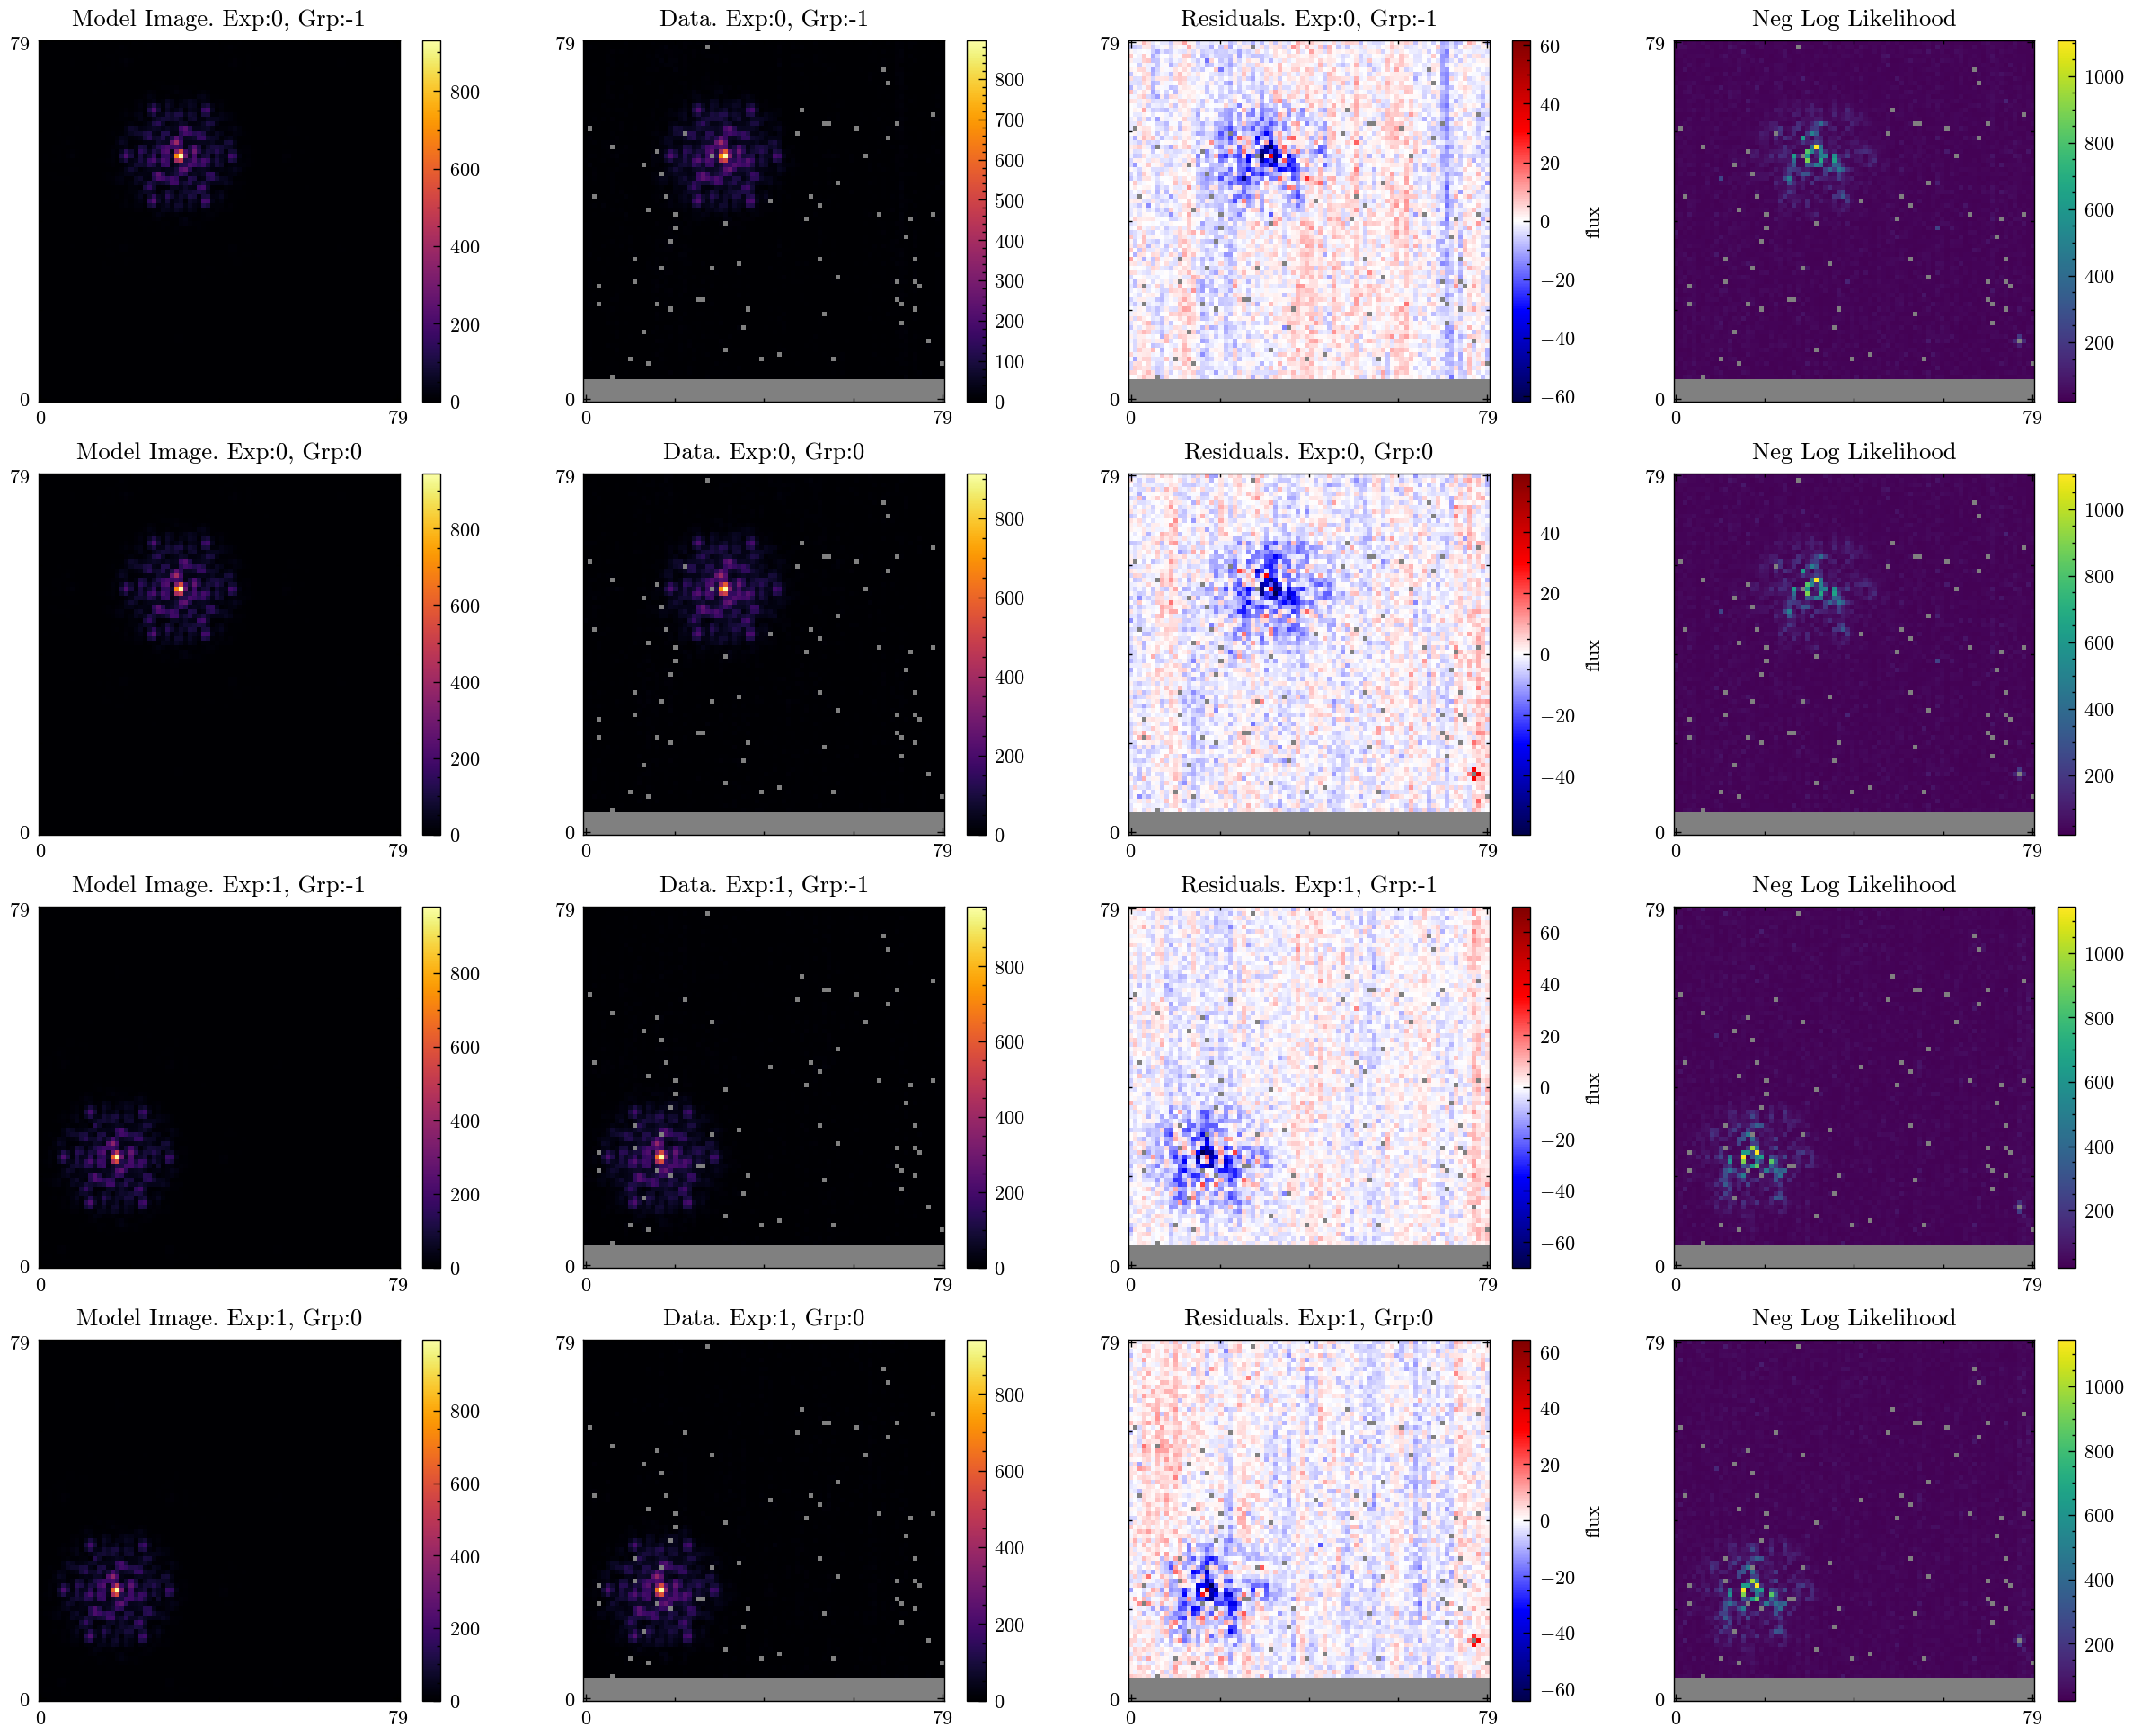

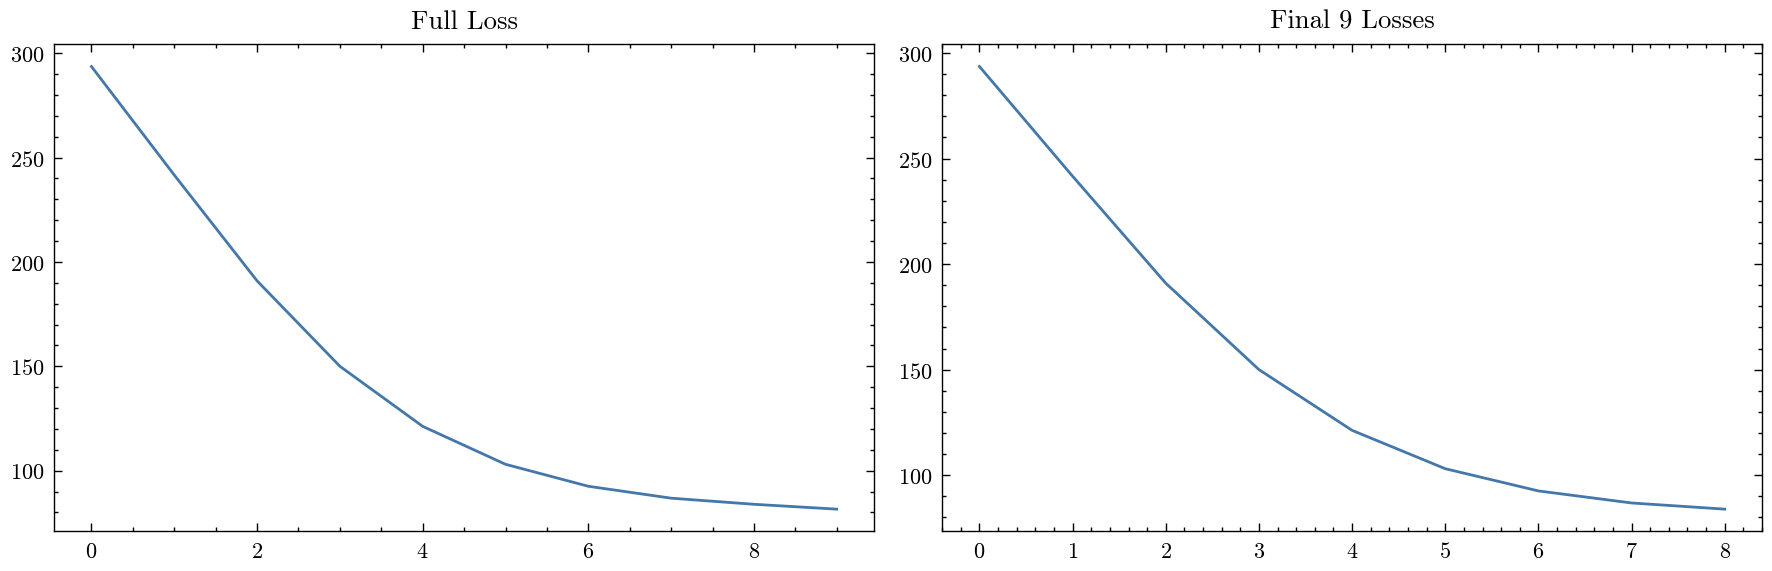

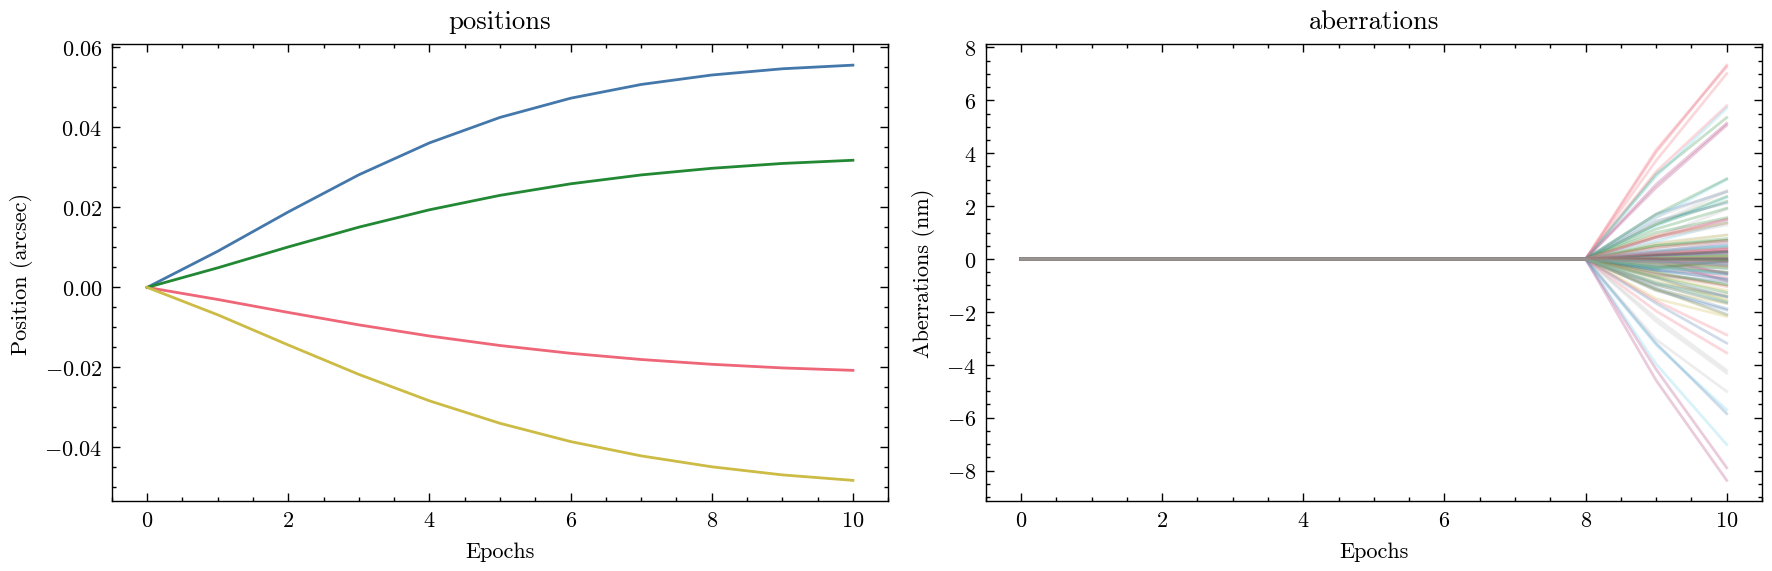

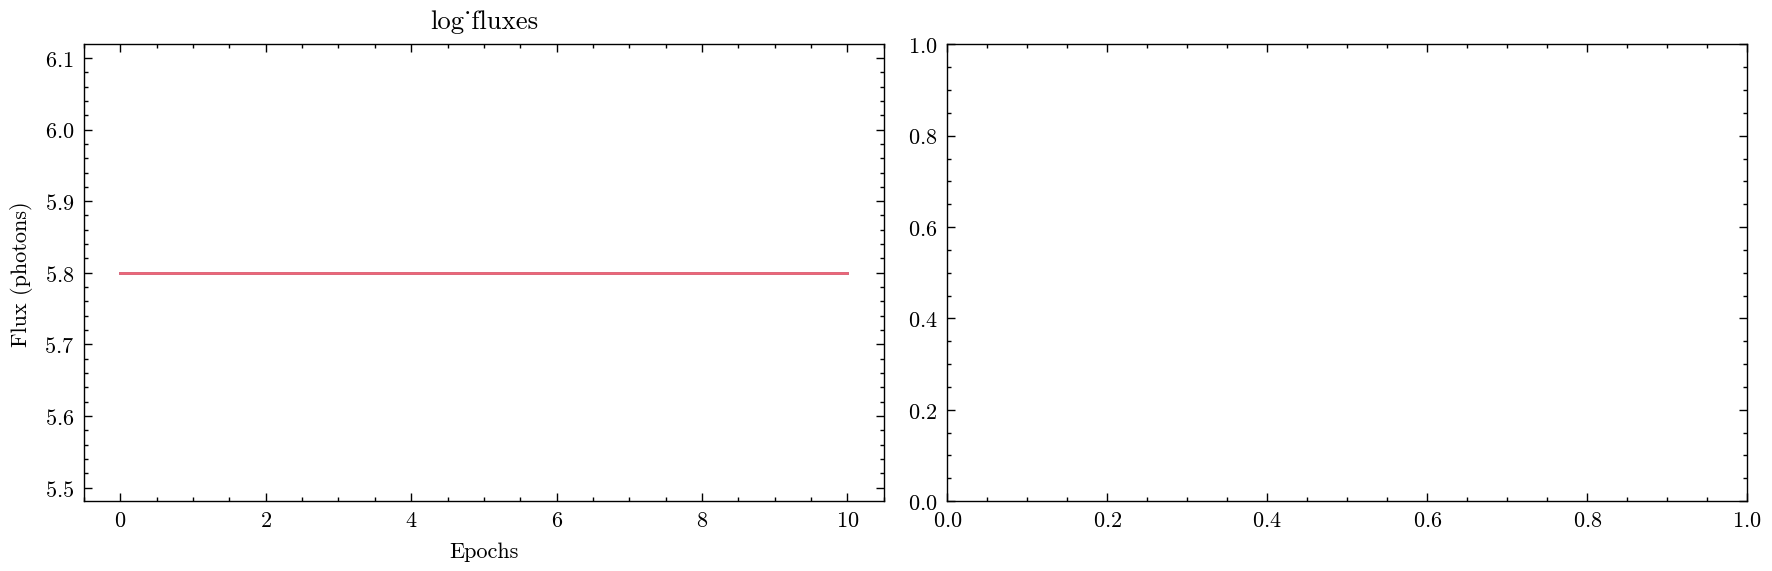

In [12]:
plotting_cal_comparison(cal_final_model, cal_exposures, model_fn)
plot_params(np.array(cal_losses), cal_params_out, k=100)

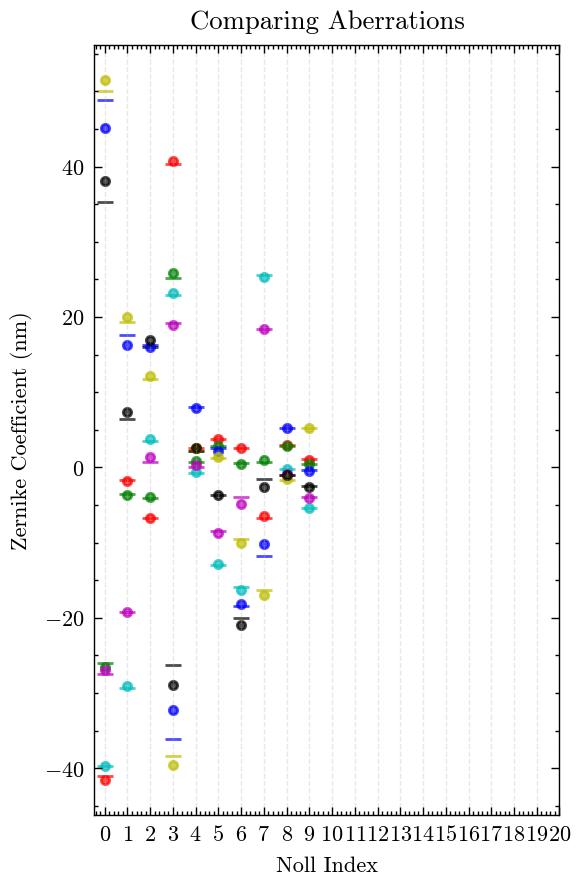

In [13]:
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ['_', '.', 'x', '+', '*', 'o', 'v', '^', '<', '>', 's', 'p', 'h', 'D', 'd', '|', '_']

plt.figure(figsize=(3, 5))
for expno, all_abs in enumerate(cal_final_model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(21))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Comparing Aberrations')
plt.show()

# serialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/abberations.zdx", cal_final_model.aberrations)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy", cal_final_model.BFE.linear)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy", cal_final_model.BFE.quadratic)


# Io

First, let's set the abberations of our Io model to be what we recovered from the calibrator.

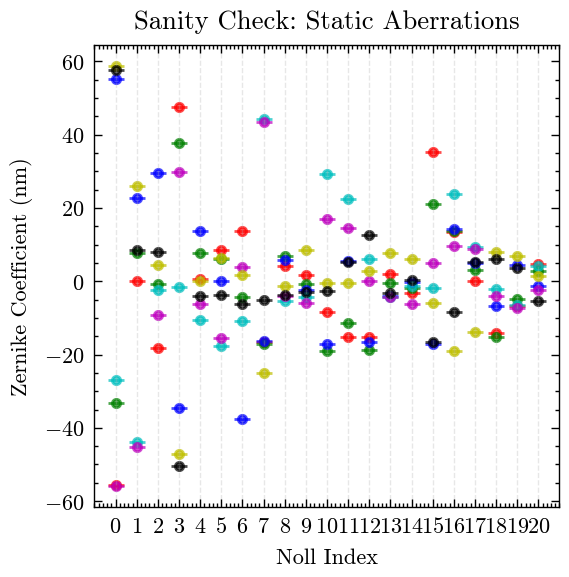

In [14]:
ab_dict = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/abberations.zdx")
bfe_linear = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy")
bfe_quadratic = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy")

static_aberations = []

for abbs in ab_dict.values():
    static_aberations.append(abbs)

static_aberations = np.array(static_aberations).mean(axis=0)

model = initial_model
for key in initial_model.keys():
    model.aberrations[key] = static_aberations
model = model.set(
    ["BFE.linear", "BFE.quadratic"],
    [bfe_linear, bfe_quadratic]
)

initial_distribution = model.distribution

plt.figure(figsize=(3, 3))
for expno, all_abs in enumerate(model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(21))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Sanity Check: Static Aberrations')
plt.show() 

## Visualisation

In [15]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    psf_ramp = model_fn(model, exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    psf_ramp = model_fn(model, exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(psf_ramp[group_idx] - data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


TypeError: dot_general requires contracting dimensions to have the same shape, got (7, 10) and (7, 21).

<Figure size 1200x1000 with 0 Axes>

# Optimisation

In [ ]:
def grad_fn(grads, args, config):
    return grads


def norm_fn(model, args={}):
    """
    Method for returning a new source object with a normalised total
    spectrum and source distribution.

    Returns
    -------
    source : Source
        The source object with the normalised spectrum and distribution.
    """
    spectrum = model.spectrum.normalise()
    distribution_floor = np.maximum(model.distribution, 0.0)
    distribution = distribution_floor / distribution_floor.sum()

    # mask = args['mask']
    # norm_dist = norm_dist * mask

    return model.set(["spectrum", "distribution"], [spectrum, distribution])


In [ ]:
delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))


config = {
    # Crude solver
    "distribution": clip(opt(1e-9, 20), 1),
    "positions": opt(1e-7, 0),
    # "aberrations":  clip(opt(2e1, 100), 1),
    "log_fluxes": opt(3e-7, 10),
    
    # # Read noise refinement
    # "OneOnFs": clip(opt(5e0, 100), 1.0),
    # "biases": clip(opt(3e3, 100), 4.0),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    initial_model,
    sci_exposures,
    loss_fn,
    300,
    config,
    norm_fn=norm_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:11
Initial Loss: 16,929.53


Loss: 16,929.53, Change: 0.0:   0%|          | 0/299 [00:00<?, ?it/s]

Compile Time: 0:20:48
Final Loss: 536.96


In [ ]:
def plotting_io_comparison(model, opt_state, exposures, losses, initial_distribution=initial_distribution):
    fin_dist = model.source.distribution

    try:
        grads = opt_state[0]['0'].inner_state[0][0].trace.distribution  # TODO this is wrong maybe
    except:
        grads = np.zeros_like(fin_dist)
    nrows = 1 + 2 * len(exposures)

    plt.figure(figsize=(15, 3*nrows))
    plt.subplot(nrows, 4, 1)
    plt.imshow(initial_distribution, cmap="afmhot_10u", vmin=0, vmax=np.nanmax(fin_dist))
    plt.colorbar(label="flux")
    plt.title("Io Initial Distribution")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    if np.nanmin(fin_dist) < 0:
        rec_vmin=None
    else:
        rec_vmin=0
    plt.subplot(nrows, 4, 2)
    plt.imshow(fin_dist, cmap="afmhot_10u", vmin=rec_vmin, vmax=np.nanmax(fin_dist))
    plt.colorbar(label="flux")
    plt.title("Io Recovered Distribution")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    plt.subplot(nrows, 4, 3)
    plt.imshow(grads, **get_residual_bounds(grads))
    plt.colorbar(label="flux / iter")
    plt.title(f"Final Gradient State. Loss: {losses[-1]:.1f}")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    for exp_idx, exp in enumerate(exposures):
        model_imgs = model_fn(model, exp)

        for grp_idx, grp_no in enumerate(np.arange(-1, 1)):
            plt.subplot(nrows, 4, 5 + 4*grp_idx + 8*exp_idx)
            plt.imshow(model_imgs[grp_no], cmap="cividis", vmin=0,)
            plt.colorbar(label="flux")
            plt.title(f"Model Image. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            plt.subplot(nrows, 4, 6 + 4*grp_idx + 8*exp_idx)
            plt.imshow(exp.data[grp_no], cmap="cividis", vmin=0,)
            plt.colorbar(label="flux")
            plt.title(f"Data. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            residuals, bound_dict = get_residuals(model_imgs[grp_no], exp.data[grp_no], return_bounds=True)
            plt.subplot(nrows, 4, 7 + 4*grp_idx + 8*exp_idx)
            plt.imshow(residuals, **bound_dict)
            plt.colorbar(label="flux")
            plt.title(f"Residuals. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            llim = exp.loglike_im(model_imgs)
            plt.subplot(nrows, 4, 8 + 4*grp_idx + 8*exp_idx)
            plt.imshow(-llim)
            plt.colorbar()
            plt.title(f"Neg Log Likelihood")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

    plt.show()


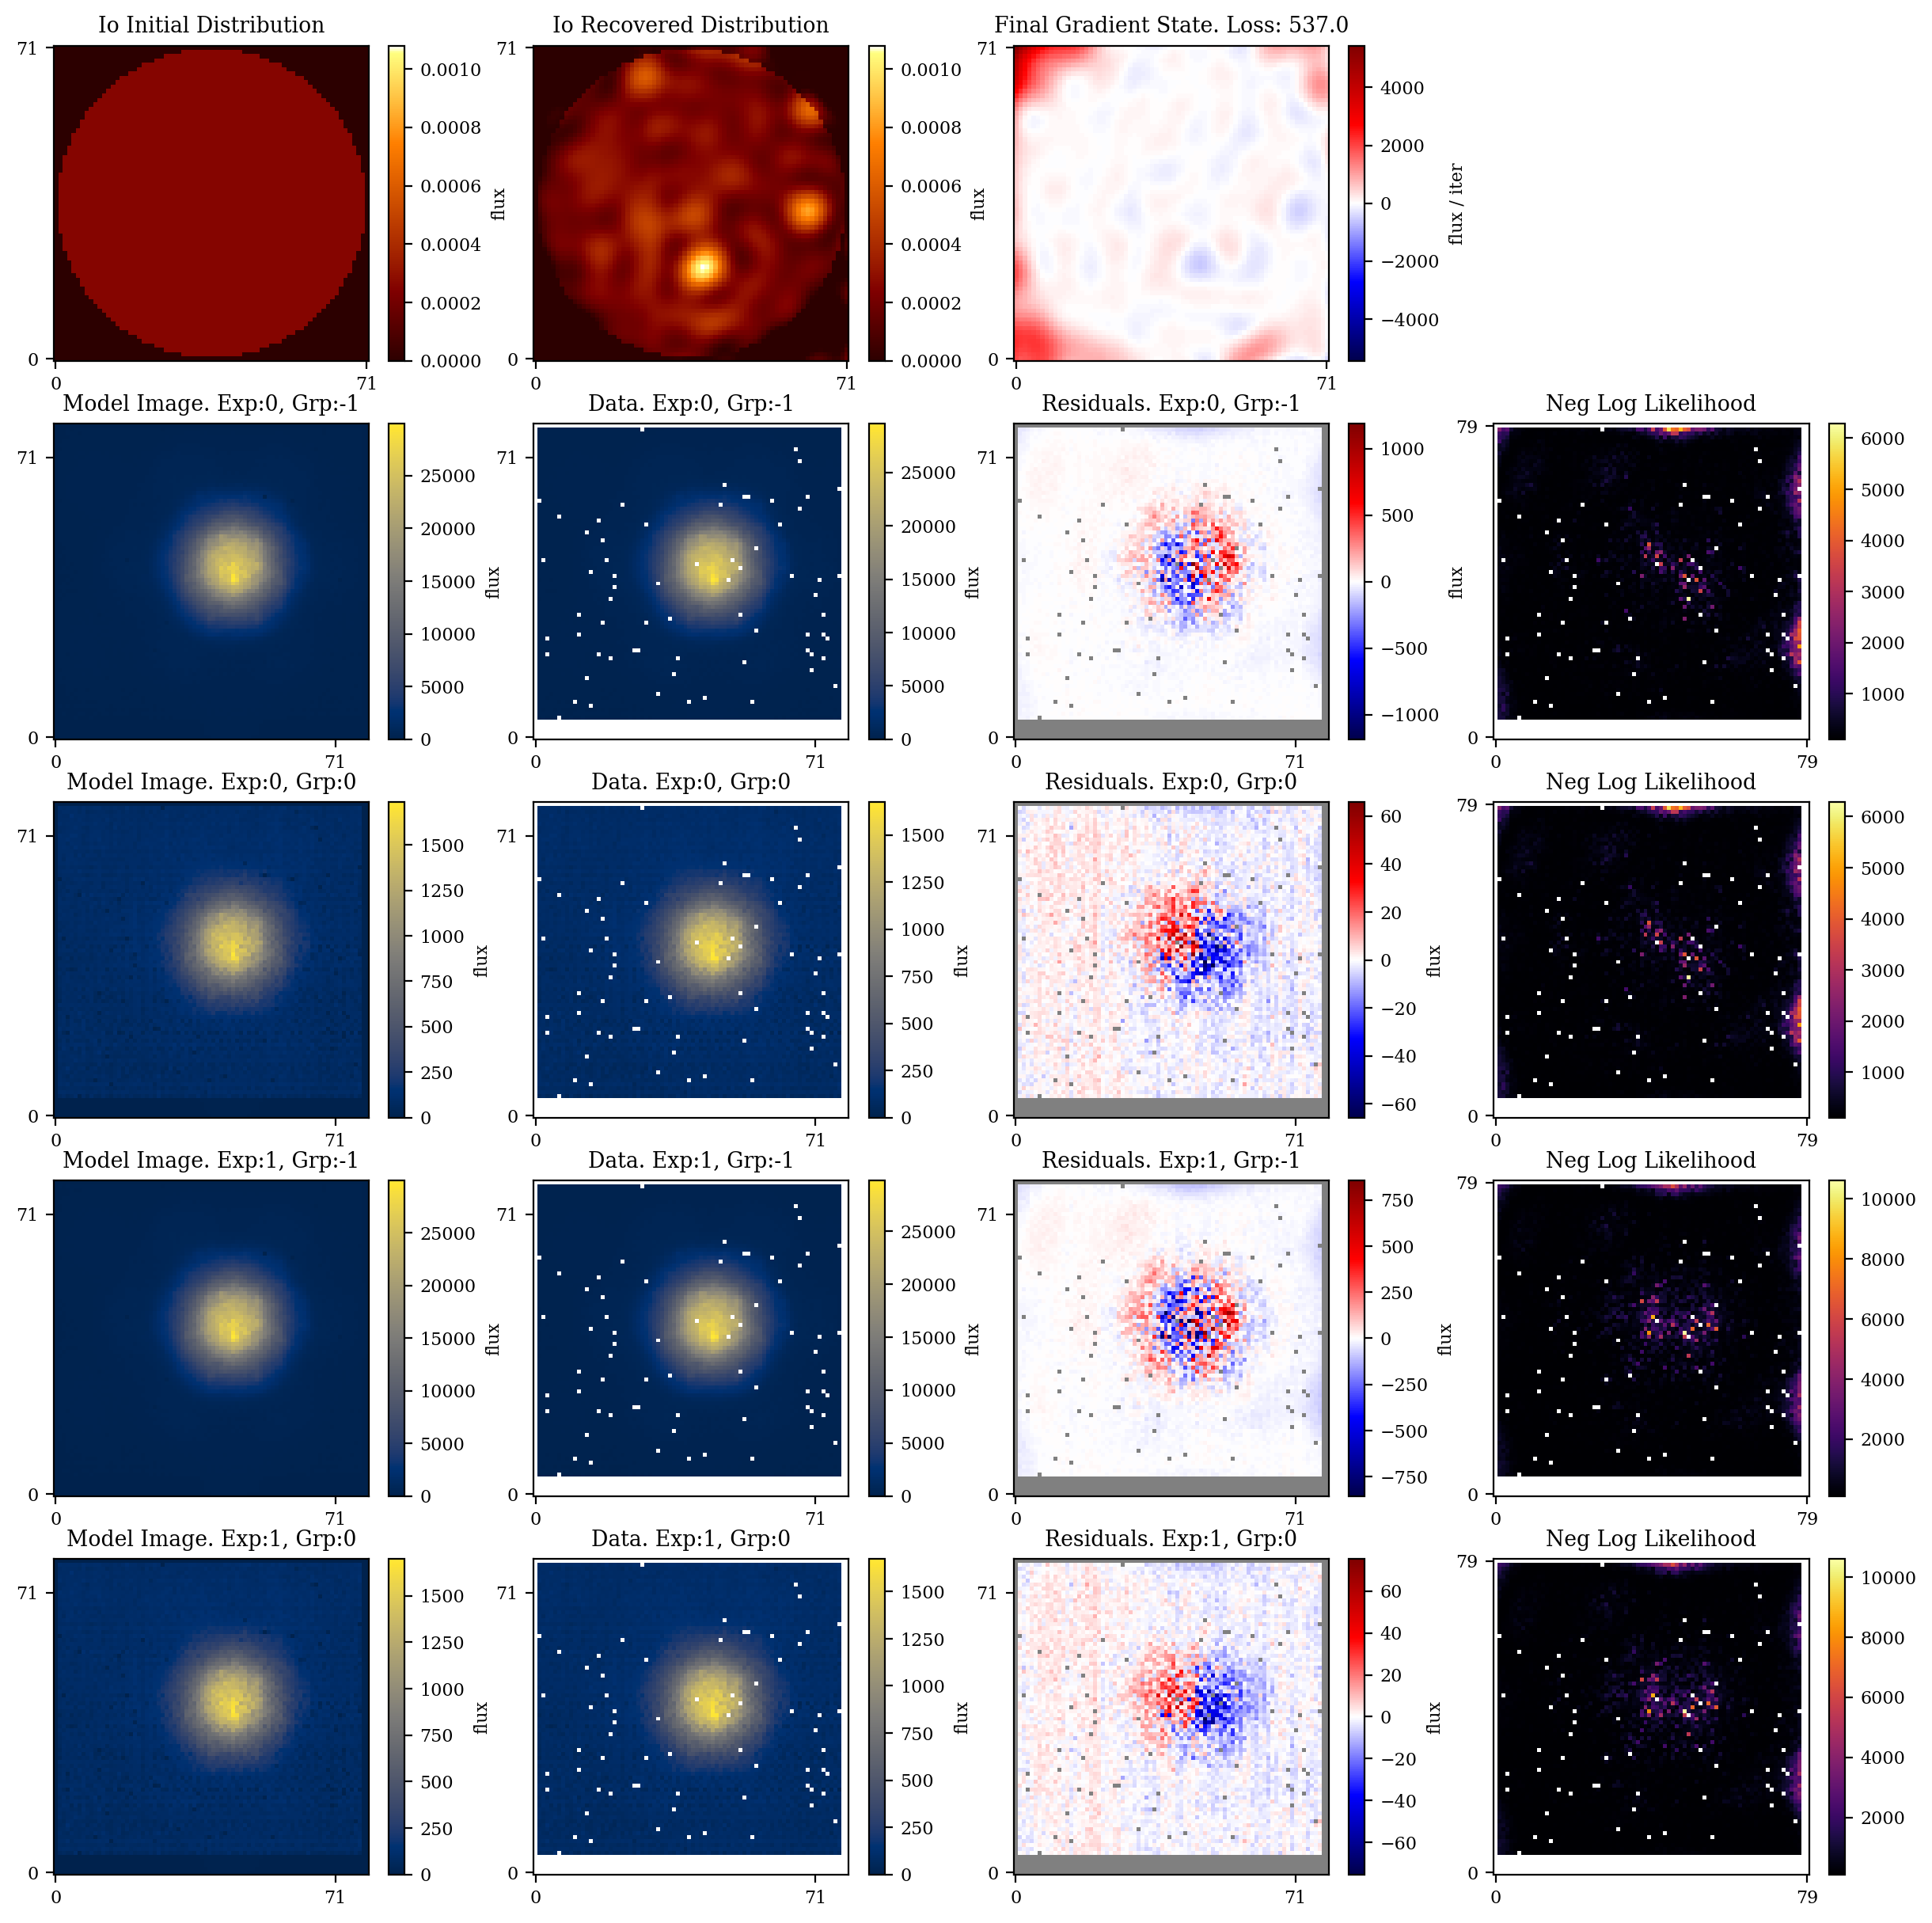

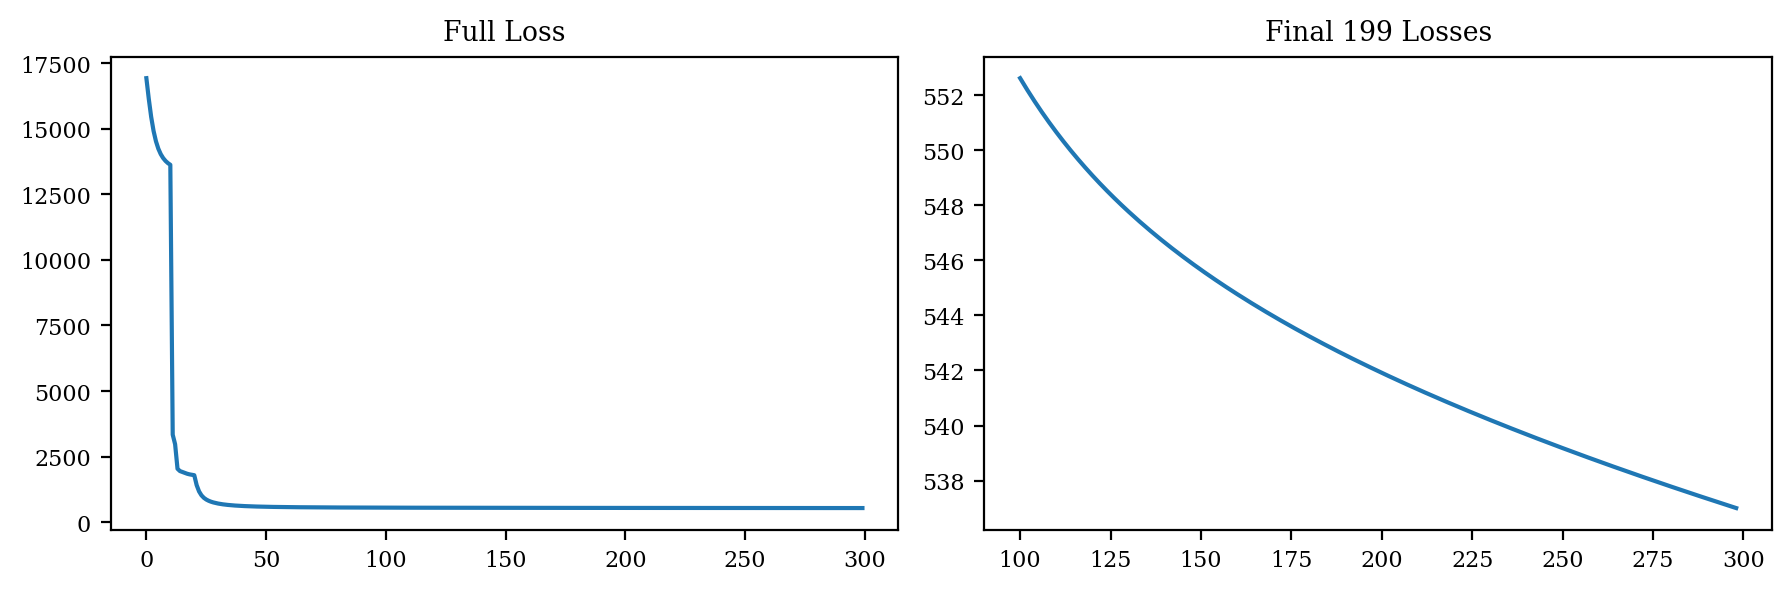

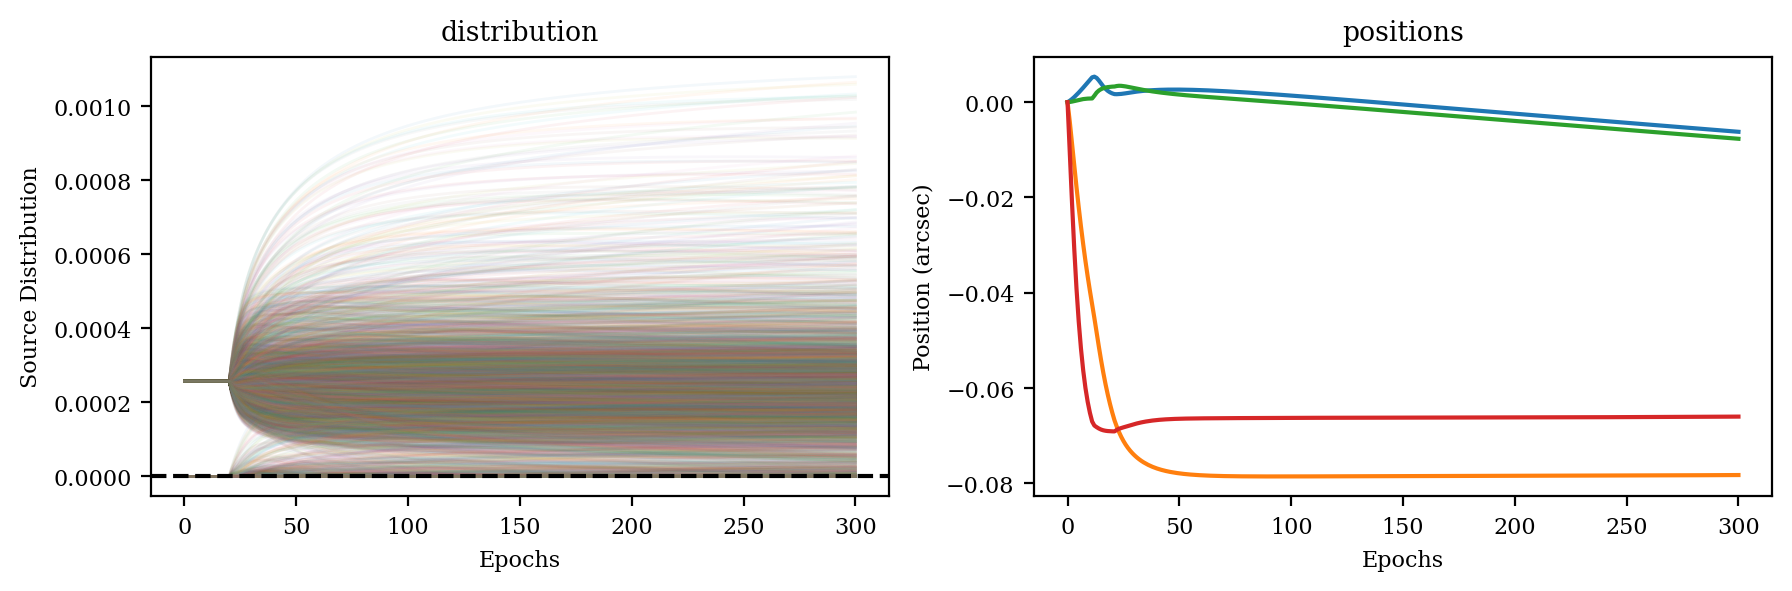

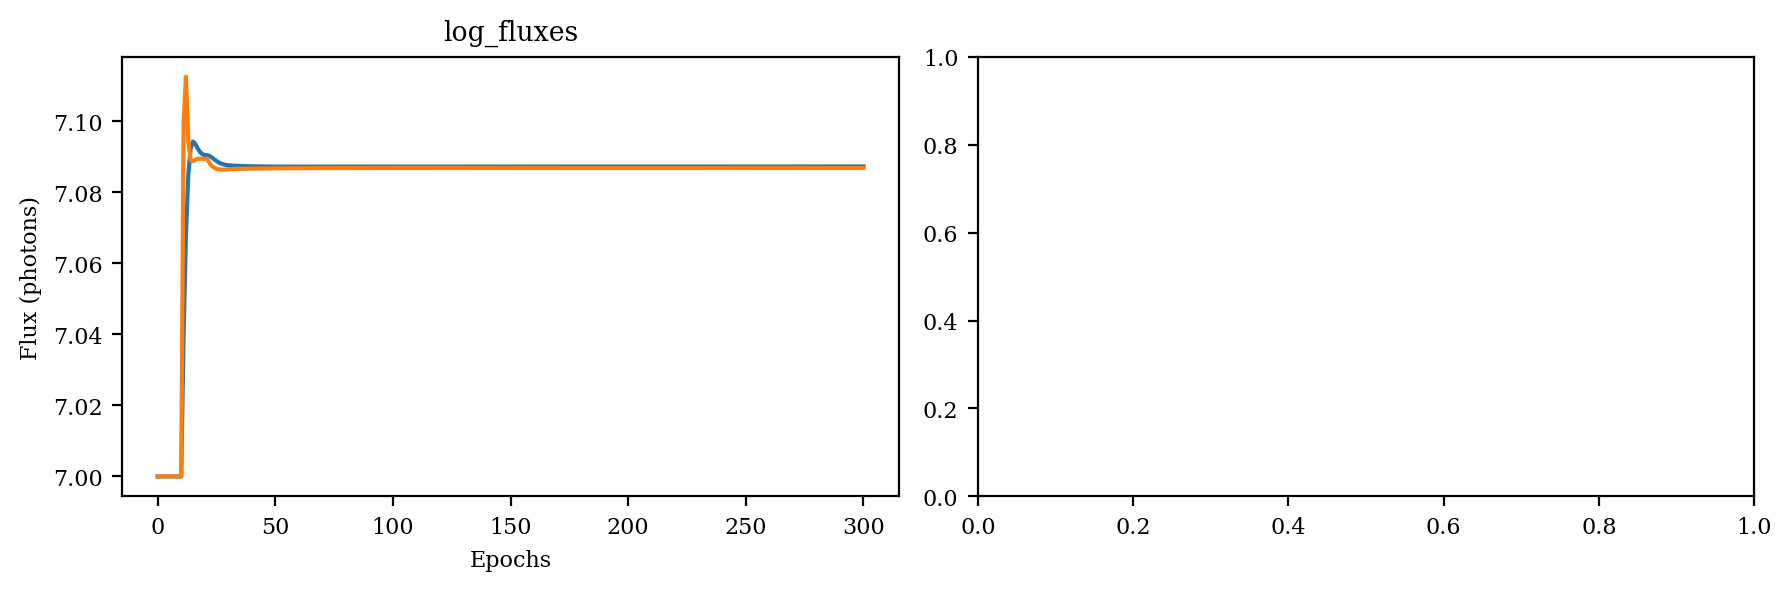

In [ ]:
plotting_io_comparison(final_model, opt_state, sci_exposures, losses)
plot_params(np.array(losses), params_out, format_fn, k=100)


In [ ]:
np.save("distribution_prior.npy", final_model.distribution)